# Cars Classification with CNN and Image Augmentation

### 1. Load libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## 2. Check Data

In [2]:
train_swift = os.listdir(os.path.join("", "train\swift"))
val_swift = os.listdir(os.path.join("", "validation\swift"))
test_swift = os.listdir(os.path.join("", "test\swift"))
print("Instances of class swift: Trian {}, Validation {}, Test {}".format(len(train_swift), len(val_swift), len(test_swift)))


Instances of class swift: Trian 1200, Validation 400, Test 400


In [3]:
train_wag = os.listdir(os.path.join("", "train\wagonr"))
val_wag = os.listdir(os.path.join("", "validation\wagonr"))
test_wag = os.listdir(os.path.join("", "test\wagonr"))
print("Instances of class wagonR: Trian {}, Validation {}, Test {}".format(len(train_wag), len(val_wag), len(test_wag)))


Instances of class wagonR: Trian 1200, Validation 400, Test 400


In [4]:
# overlapping check
val_train =[x for x in val_wag if x in train_wag]
test_train =[x for x in test_wag if x in train_wag]
val_test =[x for x in test_wag if x in val_wag]

len(val_train), len(test_train), len(val_test)

(0, 0, 0)

### Display Data

In [5]:
def display_grid(data, path, w=10, h=10, col=4, row= 5):
    fig = plt.figure(figsize=(12,8))
    for i in range(1, col*row+1):
        file= data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(row, col, i)
        plt.axis("off")
        plt.imshow(img)
    plt.show

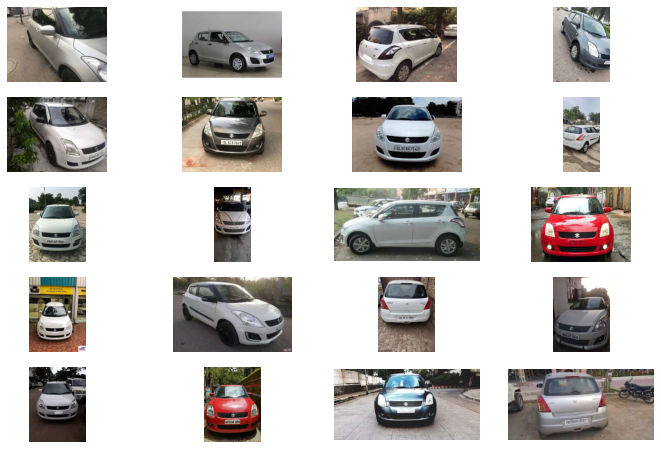

In [6]:
display_grid(train_swift, path="train\swift")

## 3. Image Augmentation

In [7]:
# data preprocessing  with augmenatation

train_dir = os.path.join("", 'train')
val_dir = os.path.join("", 'validation')

train_datagen = ImageDataGenerator(
    rescale =1.0/255,
    rotation_range= 40,
    width_shift_range= 0.2,
    height_shift_range =0.2,zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip= True,
    fill_mode= "nearest")

test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(80,80),
                                                   batch_size= 20,
                                                   class_mode= 'binary'
                                                   )
val_generator = test_datagen.flow_from_directory(val_dir,
                                                   target_size=(80,80),
                                                   batch_size= 20,
                                                   class_mode= 'binary'
                                                   )
for data_batch, labels_batch in train_generator:
    print("Data Batch shape: ", data_batch.shape)
    print("Lables Batch Shape: ", labels_batch.shape)
    break

Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Data Batch shape:  (20, 80, 80, 3)
Lables Batch Shape:  (20,)


## 4. Build Model

In [8]:
def build_cnn(display_summary =True):
    model = models.Sequential()
    model.add( layers.Conv2D(32, (3,3),  input_shape = (80, 80, 3)) )    
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(64, (3,3)) )    
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(128, (3,3)) )   
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(128, (3,3)) )    
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(512))    
    model.add(Activation("relu"))
    model.add(layers.BatchNormalization())
   
    model.add(layers.Dense(1, activation= 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizers.RMSprop(lr = 1e-4),
                  metrics = ['acc']
                  )
    model.summary()
    return model

In [9]:
model= build_cnn()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 78, 78, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 78, 78, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 37, 64)       

### Train Model

In [10]:
%%time
callback_list = [#save best model                    
                 ModelCheckpoint(filepath= 'model.h5', monitor= 'val_acc', save_best_only= True),

                 ]

history = model.fit_generator(
                            train_generator,
                            steps_per_epoch = 120,  # = num_train_images/batch size(2400/20)
                            epochs = 50,
                            validation_data = val_generator,
                            callbacks = callback_list,
                            validation_steps = 40,
                            verbose =1           # = num_valid_images/batch_size
                             )


Epoch 1/50
120/120 [==============================] - 132s 1s/step - loss: 0.8533 - acc: 0.5238 - val_loss: 0.7098 - val_acc: 0.5038
Epoch 2/50
120/120 [==============================] - 92s 765ms/step - loss: 0.7571 - acc: 0.5800 - val_loss: 0.6779 - val_acc: 0.5088
Epoch 3/50
120/120 [==============================] - 91s 758ms/step - loss: 0.7515 - acc: 0.5804 - val_loss: 0.6542 - val_acc: 0.5612
Epoch 4/50
120/120 [==============================] - 91s 762ms/step - loss: 0.7236 - acc: 0.6062 - val_loss: 0.9469 - val_acc: 0.5063
Epoch 5/50
120/120 [==============================] - 96s 799ms/step - loss: 0.6818 - acc: 0.6208 - val_loss: 0.8090 - val_acc: 0.6950
Epoch 6/50
120/120 [==============================] - 92s 768ms/step - loss: 0.6503 - acc: 0.6521 - val_loss: 0.4479 - val_acc: 0.7138
Epoch 7/50
120/120 [==============================] - 91s 759ms/step - loss: 0.6372 - acc: 0.6679 - val_loss: 0.7232 - val_acc: 0.7387
Epoch 8/50
120/120 [==============================] - 91s

### Plotting training phase

In [11]:
def plot_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
def get_best_epcoh(history):
    valid_acc = history.history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

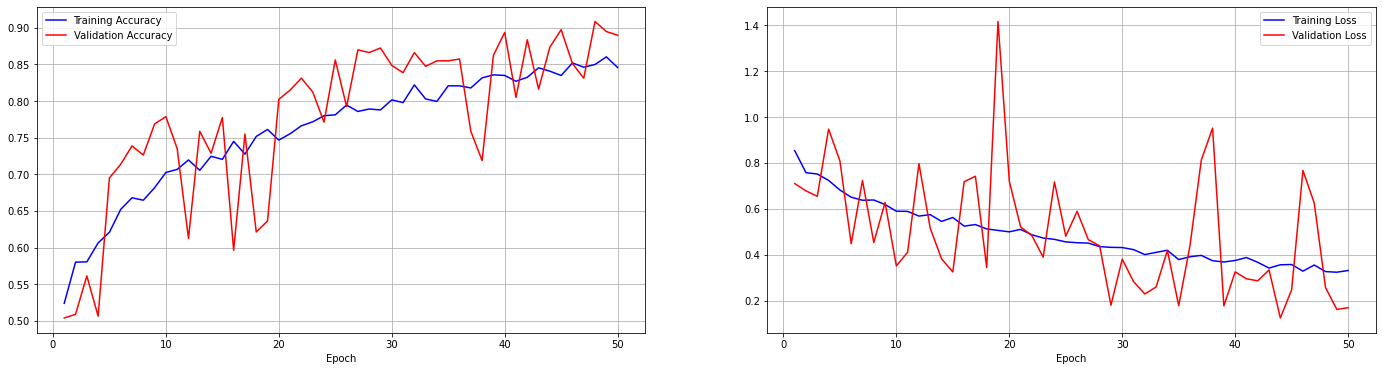

Best Validation Accuracy Score 0.90875, is for epoch 48


In [12]:
plot_results(history)
best_epoch =get_best_epcoh(history)

## 5. Save model

In [13]:
# saving model 
model_json = model.to_json()
open("arch.json", 'w').write(model_json)

# laod model 
from keras.models import model_from_json

model = model_from_json(open("arch.json").read())
model.load_weights("model.h5")